## Imports

In [30]:
# Data manipulation
import time
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

# KERAS
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.models import Sequential

# Fine-Tune your Neural Network and Save it

🎯 **Goals of this challenge**

1. ⚙️ **Fine-tune the optimizer** of a Neural Network
2. 💾 **Save**/**Load** a trained Neural Network

👩🏻‍🏫 Now that you have solid foundations about what Neural Networks are, how to design their architecture, and how to prevent them from overfitting, let's take a closer look at the `.compile(loss = ?, metrics = ?, activation = ?)` part.

## (0) The Boston Housing Dataset

📚 `Tensorflow.Keras` has several built-in datasets that you can find [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

🏠 Out of those, we are going to use the **Boston Housing Dataset**.

Our mission is to **predict the values of the houses in USD (thousands)**, and we will measure the performance of our models using the _Mean Absolute Error (MAE)_ metric.

### (0.1) Loading the Dataset

In [2]:
# Loading the dataset:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

57026/57026 [==============================] - 0s 2us/step


In [3]:
# Shape of the dataset: 
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((404, 13), (404,)), ((102, 13), (102,)))

### (0.2) Quick Glance at the Target

<AxesSubplot:ylabel='Count'>

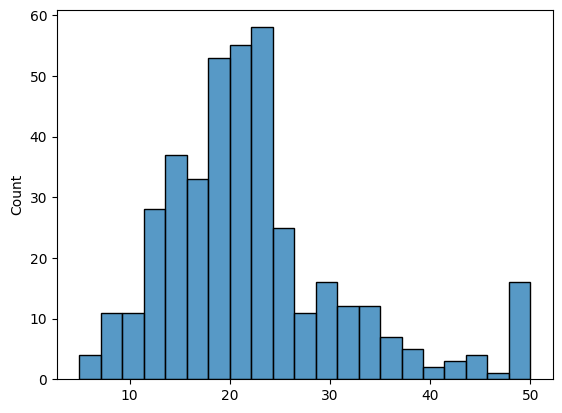

In [4]:
# Distribution of the houses' prices in the training set
sns.histplot(y_train)

In [6]:
# Null values and types of each feature:
pd.DataFrame(X_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       404 non-null    float64
 1   1       404 non-null    float64
 2   2       404 non-null    float64
 3   3       404 non-null    float64
 4   4       404 non-null    float64
 5   5       404 non-null    float64
 6   6       404 non-null    float64
 7   7       404 non-null    float64
 8   8       404 non-null    float64
 9   9       404 non-null    float64
 10  10      404 non-null    float64
 11  11      404 non-null    float64
 12  12      404 non-null    float64
dtypes: float64(13)
memory usage: 41.2 KB


In [7]:
# Statistics about the numerical columns
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


### (0.3) Minimal Data Preprocessing

👉 Here, we don't have any duplicates or missing values. Let's do the bare minimum of data preprocessing, i.e. **scaling**, and move on quickly to the modeling phase.

#### ❓Scaling your Features

Standardize `X_train` and `X_test`.

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### (0.4) Baseline Model

🧑🏻‍🏫 In a regression task, the baseline model **always predicts the average value of `y_train`**

<details>
    <summary>Really?</summary>
    
- 🐒  Yes, in most cases!
- ❗️  Be aware that this is not the only possible way of building a baseline model
- 💹  In Time Series, the baseline model predicts the **last seen value**

#### ❓Question: what would be the performance of the baseline model here?

Before running any Machine Learning algorithm or advanced Deep Learning Neural Networks, it would be great to establish a benchmark score that you are supposed to beat. Otherwise, what is the point of running a fancy algorithm if you cannot beat this benchmark score on the testing set (other than showing off)?

Compute the Mean Absolute Error on the testing set using a "dumb" prediction of the mean value of `y_train`, computed on the training set.

In [18]:
# mean of y_train
y_pred_dummy = np.mean(y_train)

# create an array of predictions using broadcasting
y_pred_test = y_pred_dummy * np.ones_like(y_test)

# MAE 
mae = np.mean(np.abs(y_test - y_pred_test))

print(f"Mean Absolute Error (Dummy Model): {mae:.4f}")


Mean Absolute Error (Dummy Model): 6.5330


In [17]:
y_pred_test

array([22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950495,
       22.3950495, 22.3950495, 22.3950495, 22.3950495, 22.3950

In [52]:
mean_absolute_error_test_baseline = mae

## (1) The Neural Network

### ❓Initializing a Neural Network with a Specific Architecture

Write a function called `initialize_model` that generates a Neural Network with 3 layers:
- Input layer: **10 neurons**, `relu` activation function, and the appropriate input dimension
- Hidden layer: **7 neurons** and the `relu` activation function
- Predictive layer: an appropriate layer corresponding to the problem we are trying to solve

In [90]:
def initialize_model():
      
    # STEP 1: ARCHITECTURE
    model = Sequential()
    model.add(layers.Dense(10, input_dim=13, activation='relu'))  # /!\ Must specify input size
    model.add(layers.Dense(7, activation='relu'))
    
    ### REGRESSION WITH 1 OUTPUT
    model.add(layers.Dense(1, activation='linear'))


    
    return model


#### ❓Number of Parameters

How many parameters do we have in this model? 
1. Compute this number yourself
2. Double-check your answer with `model.summary()`

We already covered the question about the number of parameters in a fully connected/dense network during **Deep Learning > 01. Fundamentals of Deep Learning** but it is always good to make sure you master the foundations of a new discipline 😉

In [91]:
model = initialize_model()

In [92]:
model.count_params()

225

In [93]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                140       
                                                                 
 dense_10 (Dense)            (None, 7)                 77        
                                                                 
 dense_11 (Dense)            (None, 1)                 8         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


##### 💡Answer

<details>
    <summary>Click here</summary>

- Each house has `X_train.shape[-1]` = 13 features
- Remember that a neuron is a linear regression combined with an activation function, so we will have 13 weights and 1 bias

1. First layer: **10 neurons** $\times$ (13 weights + 1 bias ) = 140 params
2. Second layer: **7 neurons** $\times$ (10 weights + 1 bias ) = 77 params
3. Third layer: **1 neuron** $\times$ (7 weights + 1 bias) = 8 params
</details>

## (2) The Optimizer

### ❓Compiling Method

Write a function that:
1. takes _both_ a **model** and an **optimizer** as arguments
2. **compiles** the model
3. returns the compiled model

Please select wisely:
- the **Loss Function** to be optimized
- the **metrics** on which the model should be evaluated

In [94]:
def compile_model(model, optimizer_name):

    # STEP 2: OPTIMIZATION METHODS - REGRESSION
    model.compile(loss='mse', optimizer=optimizer_name, metrics=['mae'])
    
    return model
    

### ❓Evaluating the Model

- Initialize the model and compile it with the `adam` optimizer
- Fit it on the training data
- Evaluate your model on the testing data

Don't forget to use an Early Stopping criterion to avoid overfitting!

<details>
    <summary>Notes</summary>

As we saw in the **"How to prevent overfitting"** challenge,  you could also use L2 penalties and Dropout Layers to prevent overfitting but:
- Early Stopping is the easiest and quickest code to implement, you just declare `es = EarlyStopping()` and call it back in the `.fit()` step
- The main goal of this challenge is to understand the **impact of the optimizer**, so stay focused 😉
</details>

In [95]:
model = compile_model(model, 'adam')

In [96]:
es = EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=100,
                    validation_split = 0.3,
          callbacks=[es])

Epoch 1/100
18/18 [==============================] - 0s 10ms/step - loss: 8235.8359 - mae: 86.1204 - val_loss: 3143.8853 - val_mae: 52.5172
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 1293.8506 - mae: 28.3054 - val_loss: 540.0131 - val_mae: 18.5375
Epoch 3/100
18/18 [==============================] - 0s 10ms/step - loss: 658.1971 - mae: 21.1545 - val_loss: 477.6489 - val_mae: 17.7304
Epoch 4/100
18/18 [==============================] - 0s 14ms/step - loss: 528.7394 - mae: 18.1490 - val_loss: 432.8369 - val_mae: 16.1034
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 467.9698 - mae: 16.5712 - val_loss: 395.6987 - val_mae: 15.4818
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 420.7794 - mae: 16.1220 - val_loss: 345.0834 - val_mae: 14.7266
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 381.2890 - mae: 15.7272 - val_loss: 313.5076 - val_mae: 14.1564
Epoch 8/100
18/18 [==============

18/18 [==============================] - 0s 7ms/step - loss: 45.7971 - mae: 4.6526 - val_loss: 83.7308 - val_mae: 6.1049
Epoch 62/100
18/18 [==============================] - 0s 9ms/step - loss: 45.0713 - mae: 4.5796 - val_loss: 80.9421 - val_mae: 6.2339
Epoch 63/100
18/18 [==============================] - 0s 10ms/step - loss: 46.4160 - mae: 4.7699 - val_loss: 85.6504 - val_mae: 6.0199
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 46.9675 - mae: 4.7883 - val_loss: 91.1766 - val_mae: 6.0847
Epoch 65/100
18/18 [==============================] - 0s 8ms/step - loss: 43.2709 - mae: 4.4772 - val_loss: 78.9265 - val_mae: 6.1046
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 42.7396 - mae: 4.4716 - val_loss: 84.6773 - val_mae: 5.9478
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 43.2861 - mae: 4.5819 - val_loss: 79.0183 - val_mae: 5.9274
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss:

In [ ]:
history.history['loss']

In [97]:
 loss, mae = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 47.8521 - mae: 4.8520


In [98]:
res = mae

In [106]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

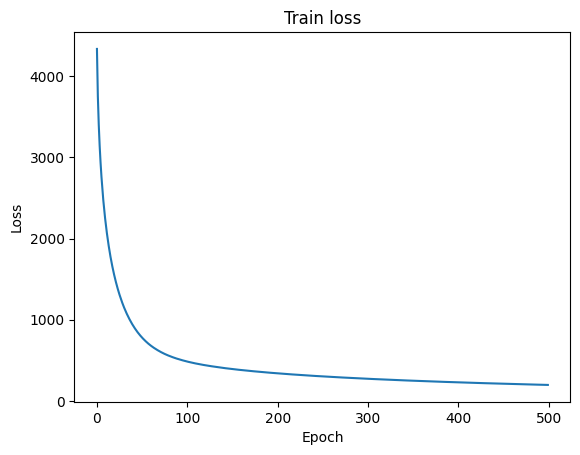

In [107]:
plot_history(history)

### Neural Network vs. Baseline

Compare the MAE on the testing set between this Neural Network and the baseline model.

In [108]:
mae_test_baseline = mean_absolute_error_test_baseline
mae_test_neuralnet = res

print(f"The MAE on the test is {mae_test_neuralnet:.4f} for the Neural Network vs. {mae_test_baseline:.4f} for the baseline")

The MAE on the test is 12.6436 for the Neural Network vs. 6.5330 for the baseline


### (2.1) Which Optimizer is the Best? 

#### ❓Trying Different Optimizers

Re-run the same model on the same data using different optimizers (in a `for` loop). 

For each optimizer:
- 📉 Plot the history of the loss (MSE) and the metric (MAE)
    - 🎁 We coded two functions: `plot_loss_mae` and `plot_loss_mse`. Which one should you use? Feel free to use it.
- ✍️ Report the corresponding Mean Absolute Error
- ⏳ Compute the time your Neural Net needed to fit the training set

📚 [`tensorflow.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

In [109]:
def plot_loss_mae(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mae'])
    ax2.plot(history.history['val_mae'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=200)
    ax2.set_ylim(ymin=0, ymax=20)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x", linewidth=0.5)
    ax1.grid(axis="y", linewidth=0.5)

    ax2.grid(axis="x", linewidth=0.5)
    ax2.grid(axis="y", linewidth=0.5)

    plt.show() 

#### Neural Network vs. Baseline - Part 2

Are your predictions better than those of the baseline model you evaluated at the beginning of the notebook?

In [110]:
compile_model(model, 'adam')

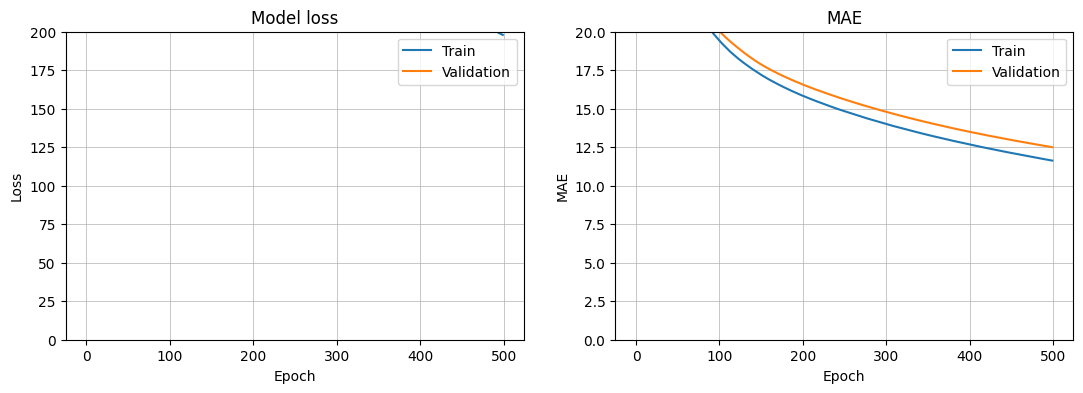

In [111]:
plot_loss_mae(history)

In [112]:
# MAE on the testing set for different optimizers
for optimizer, result in zip(['rmsprop', 'adam', 'adagrad'], results):
    print(f"The MAE on the test set with the {optimizer} optimizer is equal to {result:.2f}")

# MAE on the testing set for the baseline model    
print("-"*5)    
print(f"The MAE on the test set with the baseline model is equal to {mae_test_baseline:.2f}")

The MAE on the test set with the rmsprop optimizer is equal to 4.50
The MAE on the test set with the adam optimizer is equal to 4.46
The MAE on the test set with the adagrad optimizer is equal to 12.64
-----
The MAE on the test set with the baseline model is equal to 6.53


In [104]:
def plot_loss_mse(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mse'])
    ax2.plot(history.history['val_mse'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MSE')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=20)
    ax2.set_ylim(ymin=0, ymax=200)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x", linewidth=0.5)
    ax1.grid(axis="y", linewidth=0.5)

    ax2.grid(axis="x", linewidth=0.5)
    ax2.grid(axis="y", linewidth=0.5)

    plt.show()

4/4 [==============================] - 0s 4ms/step - loss: 37.0558 - mae: 4.4953
MAE with the rmsprop optimizer: 4.4953  reached in 7 s after 107 epochs


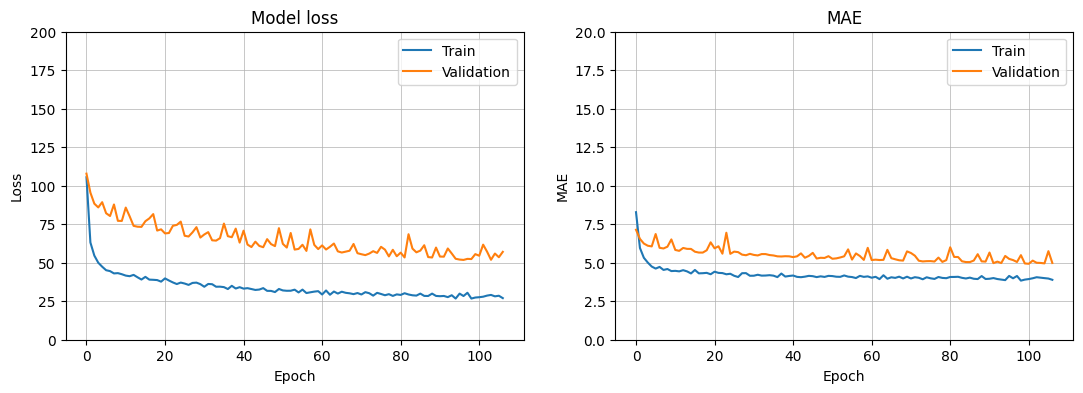

4/4 [==============================] - 0s 3ms/step - loss: 35.9842 - mae: 4.4641
MAE with the adam optimizer: 4.4641  reached in 32 s after 406 epochs


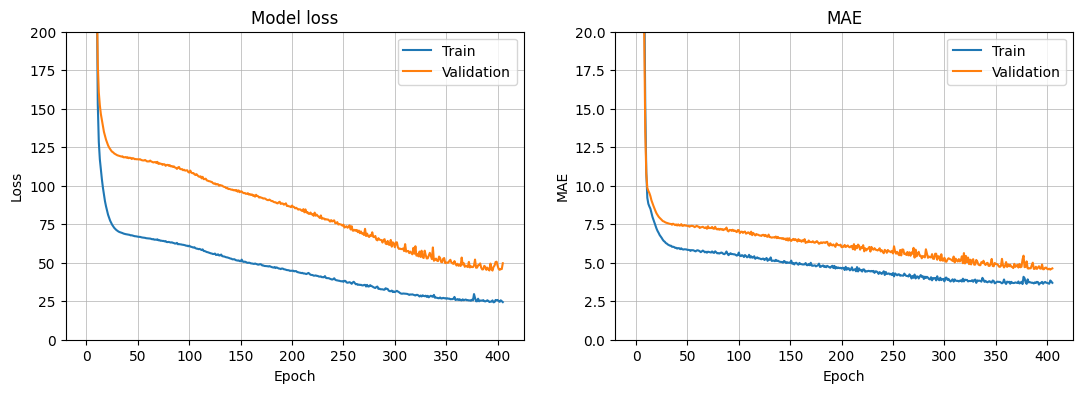

4/4 [==============================] - 0s 3ms/step - loss: 237.3382 - mae: 12.6436
MAE with the adagrad optimizer: 12.6436  reached in 41 s after 500 epochs


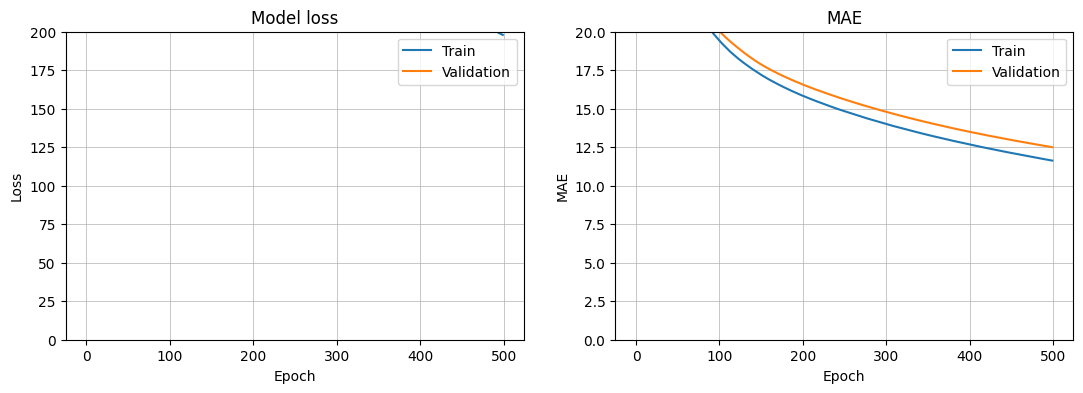

In [101]:
import time

results = []

for optimizer in ['rmsprop', 'adam', 'adagrad']:
    
    start_time = time.time()
    
    model = compile_model(initialize_model(), optimizer)

    es = EarlyStopping(patience = 10, restore_best_weights = True)

    history = model.fit(X_train, y_train, 
                        batch_size = 16, 
                        epochs = 500, 
                        validation_split = 0.3,
                        callbacks = [es], 
                        verbose = 0)

    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    
    end_time = time.time()

    print(f'MAE with the {optimizer} optimizer: {res:.4f}  reached in {(end_time - start_time):.0f} s after {len(history.epoch)} epochs')
    plot_loss_mae(history)

#### 💡Answer

<details>
    <summary>Click me</summary>

You can see that the Neural Network beat the baseline when using either `adam` or `rmsprop` as an optimizer but the result was significantly worse with the `adagrad` optimizer.

**👇 The advice from the Deep Learning community is the following 👇:**

🔥 So far, our best-performing optimizer is `adam`. Maybe a mathematician specialized in numerical methods will find a better solver in the future but for the moment, Adam is your best friend and they have already been helping us achieve remarkable results.
</details>

#### Next Steps for this Challenge

👩‍🎓 Do you remember the **Machine Learning > 04.Under The Hood** unit where we coded our **Gradient Descent** by choosing a specific `learning_rate`? It represents how slow/fast your algorithm learns. In other words, it controls the intensity of the change of the weights at each optimization of the NN, at each backpropagation!

🚀 Well, the **solvers** in Machine Learning and the **optimizers** in Deep Learning are advanced iterative methods relying on **hyperparameters**, and the `learning_rate` is one of them!

🤔 How can I control this `learning_rate`?

✅ Instead of calling an optimizer with a string ("adam", "rmsprop", etc.), which uses a default value for the Learning Rate, we will call 📚 [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) objects 📚 and tailor them to our needs.

🧑🏻‍🏫 Different Learning Rates have different consequences, as shown here: 

<img src="https://wagon-public-datasets.s3-eu-west-1.amazonaws.com/06-DL/02-Optimizer-loss-and-fitting/learning_rate.png" alt="Learning rate" height=300>

### (2.2) The Influence of the Learning Rate

### Selecting an Optimizer with a Custom Learning Rate

📚 [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

Instead of initializing the optimizer with a string, let's initialize an optimizer manually.

- Instantiate an Adam optimizer with a Learning Rate of $ \alpha = 0.1$
    - Keep the other parameters at their default values
- Use this optimizer in the `compile_model` function
- Train/fit the model
- Plot the history
- Evaluate your model

4/4 [==============================] - 0s 3ms/step - loss: 18.8576 - mae: 2.8499
Test Mean Absolute Error with a learning rate of 0.1: 2.8499


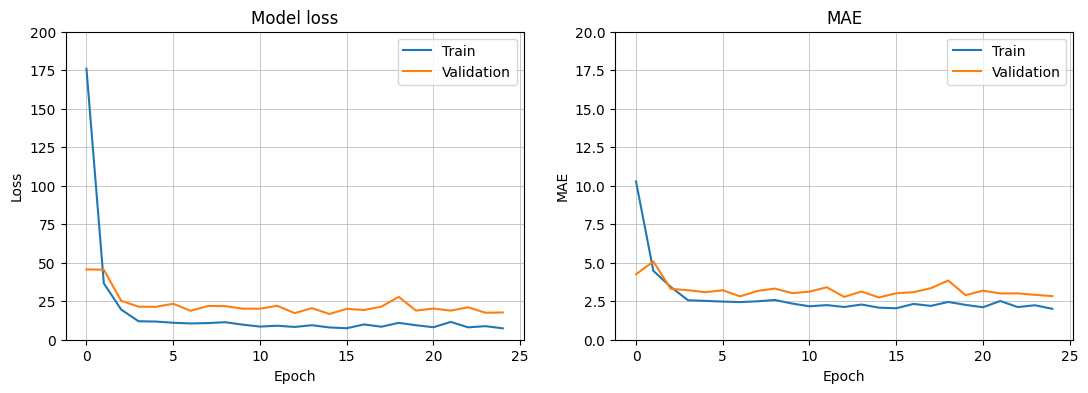

CPU times: user 3.53 s, sys: 707 ms, total: 4.24 s
Wall time: 3.1 s


In [114]:
%%time

# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate=0.1)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer
model = compile_model(model, adam)

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size = 16, 
    epochs = 1_000,
    callbacks = [es],
    verbose = 0
)

# 5. Plot the history and evaluate the model
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Test Mean Absolute Error with a learning rate of 0.1: {res:.4f}')
plot_loss_mae(history)

### ❓Playing with Learning Rates

Now, reproduce the same plots and results but for different Learning Rates.

<details>
    <summary>Remark</summary>

There is a chance that the y-axis is too large for you to visualize some results with some Learning Rates. In that case, feel free to re-write the plot function to plot only the epochs $> 10$.

</details>

4/4 [==============================] - 0s 3ms/step - loss: 24.7406 - mae: 3.6867
MAE with the adagrad optimizer: 3.6867  reached in 41 s after 1000 epochs


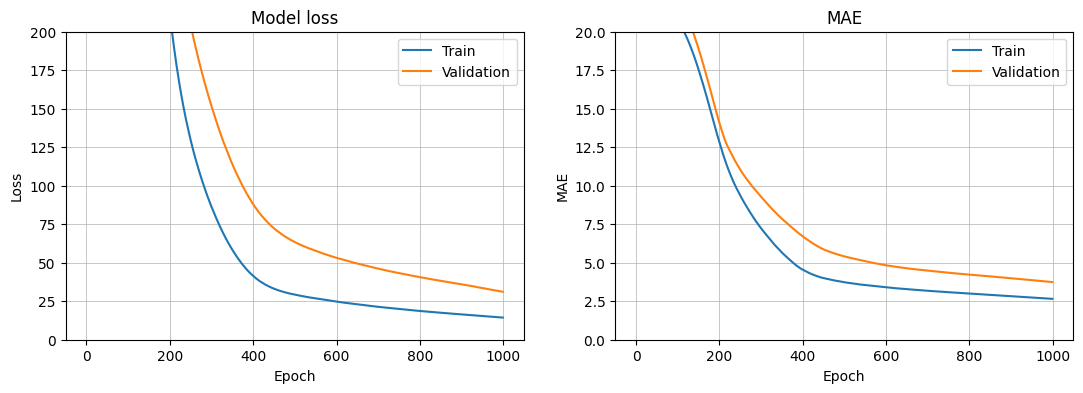

4/4 [==============================] - 0s 2ms/step - loss: 21.6413 - mae: 3.0063
MAE with the adagrad optimizer: 3.0063  reached in 41 s after 333 epochs


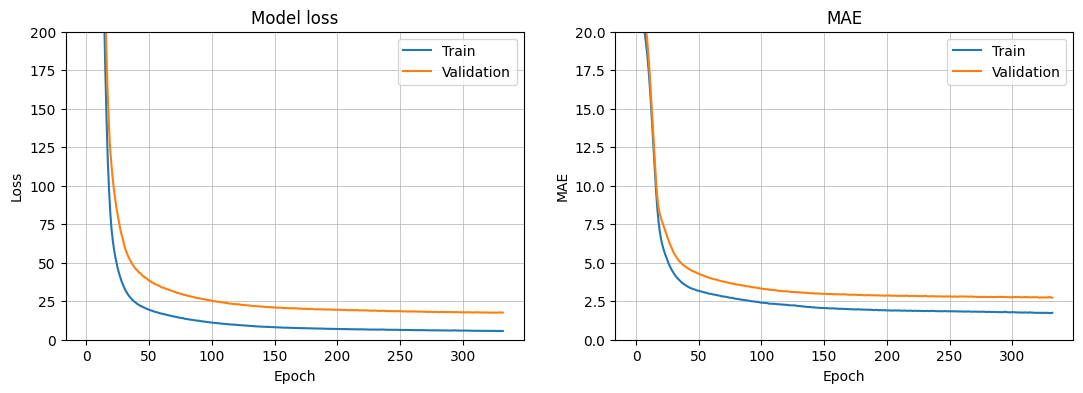

4/4 [==============================] - 0s 2ms/step - loss: 20.1587 - mae: 2.7915
MAE with the adagrad optimizer: 2.7915  reached in 41 s after 75 epochs


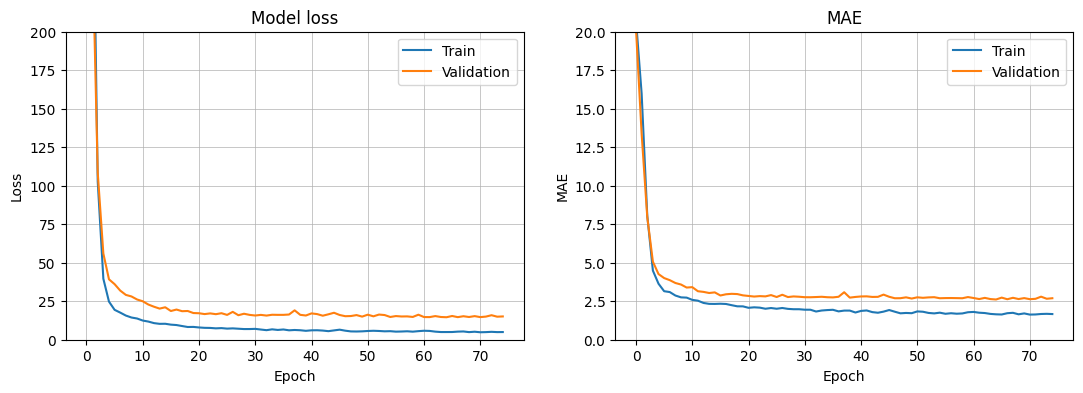

4/4 [==============================] - 0s 2ms/step - loss: 18.2939 - mae: 2.7915
MAE with the adagrad optimizer: 2.7915  reached in 41 s after 43 epochs


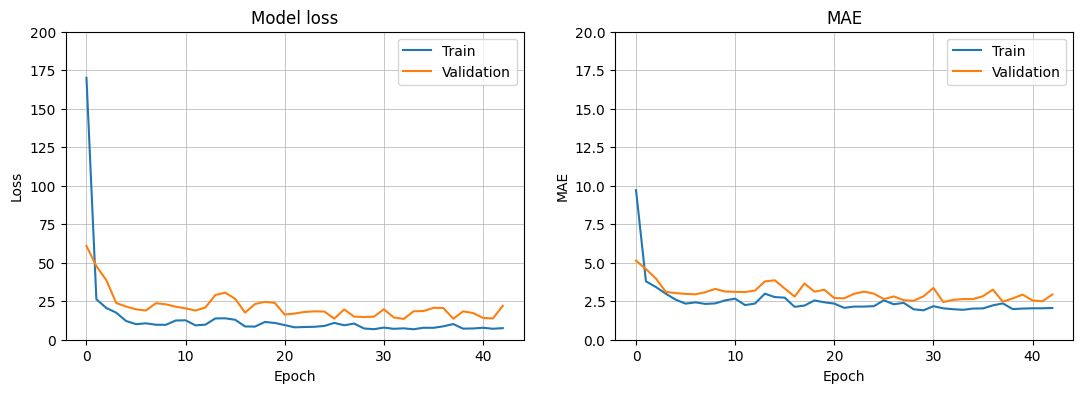

4/4 [==============================] - 0s 2ms/step - loss: 84.3344 - mae: 6.5151
MAE with the adagrad optimizer: 6.5151  reached in 41 s after 15 epochs


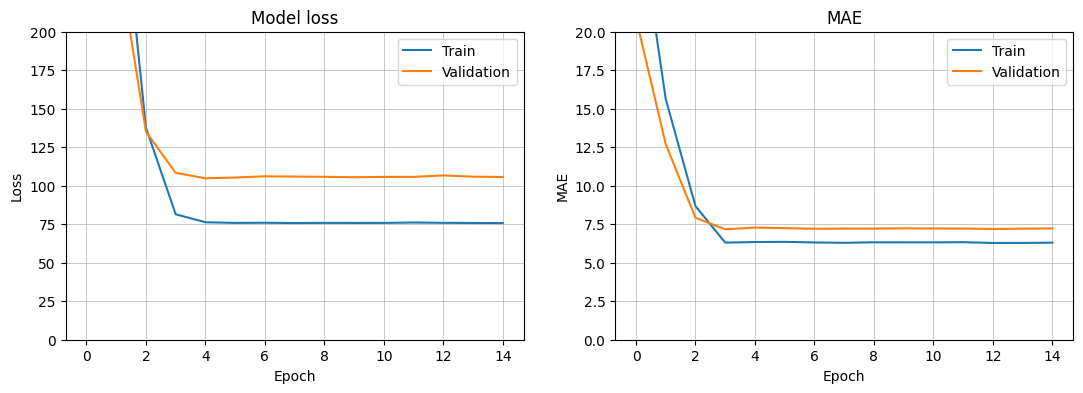

4/4 [==============================] - 0s 3ms/step - loss: 84.4173 - mae: 6.5137
MAE with the adagrad optimizer: 6.5137  reached in 41 s after 36 epochs


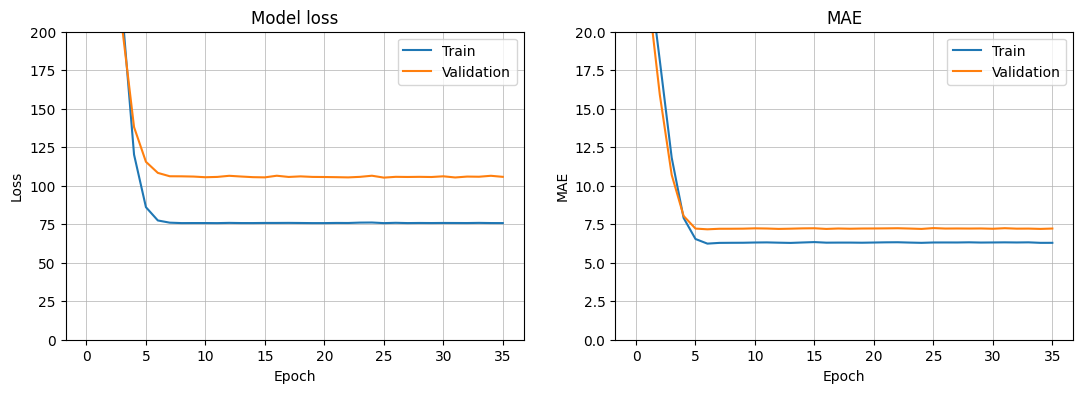

In [117]:
import time

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 2]
results = []

for learning_rate in learning_rates:
        

    # 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
    adam = Adam(learning_rate)

    # 2. Initializing the model
    model = initialize_model()

    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)

    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(
        X_train_scaled,
        y_train, 
        validation_split = 0.3,
        shuffle = True,
        batch_size = 16, 
        epochs = 1_000,
        callbacks = [es],
        verbose = 0
    )

    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test_scaled, y_test)[1]
    results.append(res)
    
    
    print(f'MAE with the {optimizer} optimizer: {res:.4f}  reached in {(end_time - start_time):.0f} s after {len(history.epoch)} epochs')
    plot_loss_mae(history)

In [138]:
# mae 
results

[3.686737060546875,
 3.0063135623931885,
 2.791496753692627,
 2.791483163833618,
 6.515064239501953,
 6.513725280761719]

## (3) The Loss

---

❗️It's important to clearly understand the **difference between losses and metrics**❗️

- 🏋🏻‍♀️ The **Loss Functions** are computed **during the training procedure**
    - For regression tasks, the classic Loss Functions are **(Root) Mean Squared Error** ((R)MSE), **Mean Absolute Error** (MAE), and **Mean Squared Logarithmic Error** (MSLE, as seen in the Kaggle challenge)
    - For classification tasks, the classic Loss Functions are **Binary Crossentropy** (also known as LogLoss), **Categorical Crossentropy**, Hinge Loss, etc.
- 🧑🏻‍🏫 The **metrics** are computed to evaluate your models, **after training them**!
    - For regression tasks, common metrics are MSE, MAE, RMSE, Coefficient of Determination (R2), etc.
    - For classification tasks, common metrics are Accuracy, Recall, Precision, and F1-Score
- 👀 Notice that some metrics can also be used as Loss Functions, as long as they are differentiable! (e.g. the **MSE**)

If these notions are not clear, we strongly advise reviewing **Machine Learning > 03.Performance Metrics** and **Machine Learning > 05.Model Tuning**

---

⏩ Alright, after this reminder, let's move on:

### ❓Optimizing a Model with a certain Loss Function

- Run the same NN, once with `mae` as the loss, and once with `mse`
- In both cases, compare `mae_train`, `mae_val`, `mse_train`, `mse_val`

In [119]:
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(0.01)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer
model = compile_model(model, adam)

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(X_train_scaled,
                    y_train, 
                    validation_split = 0.3,
                    shuffle = True,
                    batch_size = 16, 
                    epochs = 1_000,
                    callbacks = [es])

Epoch 1/1000
18/18 [==============================] - 0s 8ms/step - loss: 411.3854 - mae: 18.5403 - val_loss: 339.3289 - val_mae: 15.9749
Epoch 2/1000
18/18 [==============================] - 0s 9ms/step - loss: 134.8935 - mae: 9.1668 - val_loss: 90.8236 - val_mae: 6.6535
Epoch 3/1000
18/18 [==============================] - 0s 10ms/step - loss: 45.3325 - mae: 4.9626 - val_loss: 58.8565 - val_mae: 5.0272
Epoch 4/1000
18/18 [==============================] - 0s 8ms/step - loss: 30.5915 - mae: 4.0333 - val_loss: 41.3549 - val_mae: 4.2670
Epoch 5/1000
18/18 [==============================] - 0s 6ms/step - loss: 24.3574 - mae: 3.6370 - val_loss: 36.3953 - val_mae: 3.9156
Epoch 6/1000
18/18 [==============================] - 0s 7ms/step - loss: 21.3675 - mae: 3.3672 - val_loss: 32.5969 - val_mae: 3.8001
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 19.8603 - mae: 3.3081 - val_loss: 30.3767 - val_mae: 3.5671
Epoch 8/1000
18/18 [==============================] - 0s

In [133]:
mse_train = history.history['mae'][-1]
mse_train

1.784981608390808

In [134]:
mse_val = history.history['val_mae'][-1]
mse_val

2.730766534805298

In [148]:
def compile_model(model, optimizer_name):

    # STEP 2: OPTIMIZATION METHODS - REGRESSION
    model.compile(loss='mae', optimizer=optimizer_name, metrics=['mae'])
    
    return model
    

In [150]:
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(0.01)

# 2. Initializing the model
model = initialize_model()

# 3. Compiling the model with the custom Adam optimizer
model = compile_model(model, adam)

# 4. Training the neural net
es = EarlyStopping(patience = 10)
history1 = model.fit(X_train_scaled,
                    y_train, 
                    validation_split = 0.3,
                    shuffle = True,
                    batch_size = 16, 
                    epochs = 1_000,
                    callbacks = [es])

Epoch 1/1000
18/18 [==============================] - 0s 8ms/step - loss: 21.2064 - mae: 21.2064 - val_loss: 21.4509 - val_mae: 21.4509
Epoch 2/1000
18/18 [==============================] - 0s 5ms/step - loss: 18.0685 - mae: 18.0685 - val_loss: 16.4485 - val_mae: 16.4485
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 10.6046 - mae: 10.6046 - val_loss: 8.9298 - val_mae: 8.9298
Epoch 4/1000
18/18 [==============================] - 0s 5ms/step - loss: 6.4757 - mae: 6.4757 - val_loss: 7.3074 - val_mae: 7.3074
Epoch 5/1000
18/18 [==============================] - 0s 5ms/step - loss: 4.8944 - mae: 4.8944 - val_loss: 5.7710 - val_mae: 5.7710
Epoch 6/1000
18/18 [==============================] - 0s 5ms/step - loss: 3.5928 - mae: 3.5928 - val_loss: 4.7641 - val_mae: 4.7641
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.1493 - mae: 3.1493 - val_loss: 4.0994 - val_mae: 4.0994
Epoch 8/1000
18/18 [==============================] - 0s 4ms/step 

In [130]:
mae_train = history1.history['mae'][-1]
mae_train

1.6666524410247803

In [131]:
mae_val = history1.history['val_mae'][-1]
mae_val

3.048238754272461

### 💡Learnings

🤔 When you work on this regression task, you want to achieve the lowest MAE in the testing set at the end, right? So why wouldn't we use it directly as a Loss Function that would decrease with the number of epochs? 

<details>
    <summary>Answer</summary>

Well, even the Deep Learning research community is still trying to answer these types of questions rigorously.

One thing is sure: in Deep Learning, you will never really reach the "global minimum" of the true Loss Function (the one computed using your entire training set as one single batch). So, in your first model (minimizing the MAE loss), your global MAE minimum has clearly **not** been reached (otherwise you could never beat it). 

Why? It may well be that the minimization process of the second model has performed better. Maybe because the Loss Function "energy map" is "smoother" or more "convex" in the case of MSE loss? Or maybe your hyper-parameters are best suited to the MSE than to the MAE loss?

</details>

#*******************for me first one is better, order of code, first one loss='mse' and the second one loss='mae'************

## (4)  Saving and Loading a Trained Neural Network

🤯 Imagine that you trained a complex Neural Network (many layers/neurons) on a huge dataset. The parameters of your Deep Learning Model (weights and biases) are now optimized and you would like to share these weights with a teammate who wants to predict a new data point. Would you give this person your notebook for them to run it and then predict the new data point? Hell no, we have a much better solution:
- 💾 Save the weights of the optimized Neural Network
- 🤝 Your friend/colleague/teammate/classmate can use them to predict a new data point

### ❓Training a Good Model

- Try to reach an MAE on the testing set that is lower than 5 (_feel free to re-create the architecture and redefine your compiling parameters in this section!_)
    - Remember: we are predicting house prices, so a mistake of less than 5.000 USD is already good in the real estate industry)

- Whether you managed to reach it or not, move on to the "Saving a Model" section after a few attempts.

In [151]:
mae_test = 2.79

In [152]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'solution',
    mae_test = mae_test
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/mahshid/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/mahshid/code/mahshid90/06-Deep-Learning/02-Optimizer-loss-and-fitting/data-finetune-your-neural-network/tests
plugins: anyio-3.6.2, typeguard-2.13.3, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_solution.py::TestSolution::test_is_score_beat_baseline PASSED       [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/solution.pickle

git commit -m 'Completed solution step'

git push origin master



### ❓Saving a Model

📚 [`tf.keras.models.save_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model)

Save your model using the `.save_model(model, 'name_of_my_model')` method.

In [153]:
models.save_model(model, 'my_model')

INFO:tensorflow:Assets written to: my_model/assets


### ❓Loading a Model

📚 [`tf.keras.models.load_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model)

- Load the model that you've just saved using `.load_model('name_of_your_model')` and store it into a variable called `loaded_model`
- Evaluate it on the testing data to check that it gives the same result as before

In [154]:
loaded_model = models.load_model('my_model')

In [155]:
loaded_model.evaluate(X_test_scaled, y_test)[1] 

4/4 [==============================] - 0s 3ms/step - loss: 2.9492 - mae: 2.9492


2.949211359024048

## (5) (Optional) Exponential Decay

❗️Warning❗️ 

- This section is optional and for advanced practitioners
- The next question is not essential and can be indeed skipped as many algorithms can be run without such optimization

🧑🏻‍🏫 Instead of keeping a fixed Learning Rate, you can change it from one iteration to the other, with the intuition that at first, you need a large Learning Rate to learn fast, and as the Neural Network converges and gets closer to the minimum of the Loss Function, you can decrease the value of the Learning Rate. This is called a **scheduler**. 

### ❓The Exponential Decay Scheduler

Use the 📚 [Exponential Decay Scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) 📚 in the `adam` optimizer, and run it on the previous data.

Use the following parameters:

```python
initial_learning_rate = 0.1 # start with a value higher than the default Adam value (0.001)

lr_schedule = ExponentialDecay(
    # Every 2000 iterations, multiply the learning rate by 0.5
    initial_learning_rate, decay_steps = 200, decay_rate = 0.5,
)
```

In [ ]:
# We have approximately 18 iterations per epoch:
#       404  observations 
#      x 70% after holding out 30% for the validation set
#      / 16  batch size
X_train.shape[0] * 0.7 / 16

In [ ]:
# YOUR CODE HERE

## 🏁 Congratulations!

💾 Do not forget to `git add/commit/push` your notebook...

🚀 ... and move to the next challenge!

---

**Further reading after your bootcamp:**

The **Boston Housing Dataset** was deprecated by Scikit-Learn for ethical reasons, and TensorFlow may also replace it in the future.

A certain M. Carlisle wrote a 12-min read article called ["Racist Data Destruction"](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8) to investigate this problem.